下面是一个简单的教程，我们将使用scutquant的scutquant、alpha、report和executor模块完成一个从用原始数据构建因子，特征工程和数据清洗，划分数据集，使用模型做信号合成，并根据预测值进行模拟实盘回测的全过程 :)

用到的各模块的主要功能如下:  

* scutquant: 主要负责除了因子构建以外的数据处理，包括数据清洗，数据集划分和pca等等，也提供一些可直接调用的简单的模型（主要是树模型和线性模型）
* alpha: 主要负责与因子相关的数据处理，并批量生成因子（对单因子的精细处理可通过底层的operators模块实现），提供单因子回测函数
* report: 主要负责对计算结果生成报告，无论是因子数据（single_factor_ana）还是分组报告（group_return_ana）还是整个回测的报告
* executor: 根据预测值和策略按datetime（可以是任何频率的数据）执行回测，并返回一个executor对象，其中包含了用户的账户对象user_account，内含回测的全部细节

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/csidata.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["datetime", "instrument"], inplace=True)
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2006-01-04 000001.SZ    6.13   6.33   6.12   6.28       6.14    0.14   2.2800   
           000002.SZ    4.40   4.67   4.40   4.66       4.31    0.35   8.1200   
           000012.SZ    4.70   4.75   4.55   4.70       4.62    0.08   1.7300   
           000016.SZ    3.52   3.58   3.52   3.57       3.52    0.05   1.4200   
           000021.SZ    7.99   8.40   7.99   8.32       8.00    0.32   4.0000   
...                      ...    ...    ...    ...        ...     ...      ...   
2023-07-27 688363.SH   94.34  96.20  94.00  95.90      94.70    1.20   1.2672   
           688396.SH   55.25  56.25  54.92  55.36      54.92    0.44   0.8012   
           688561.SH   48.96  49.38  48.80  48.83      49.11   -0.28  -0.5701   
           688599.SH   36.40  37.29  36.36  36.39      36.61   -0.22  -0.6009   
           688981.SH   50.01  50.14  49.20  49.39      50.15   -0.76  -1.5155   

                             amount     volume  
datetime   instrument                           
2006-01-04 000001.SZ    96989.00660  154450.68  
           000002.SZ   175187.06570  389310.43  
           000012.SZ    18863.86250   40399.61  
           000016.SZ     5131.87930   14426.65  
           000021.SZ    27657.17080   33526.60  
...                             ...        ...  
2023-07-27 688363.SH   276386.76000   28957.40  
           688396.SH   218456.02400   39268.57  
           688561.SH    76213.86113   15532.40  
           688599.SH   456467.83070  124308.87  
           688981.SH   812613.12370  163390.62  

[1240545 rows x 9 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
X = alpha.qlib158(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

open1     open2     open3     open4     open5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.998085  0.962660  0.961277  0.953936  0.947979   
           688396.SH   0.986727  0.979818  0.985455  0.981818  0.985273   
           688561.SH   0.973039  0.970809  0.991689  1.003446  1.012568   
           688599.SH   0.986260  0.989283  1.002748  1.006046  1.016488   
           688981.SH   0.982118  0.984730  0.991159  0.994575  0.984529   

                         close1    close2    close3    close4    close5  ...  \
datetime   instrument                                                    ...   
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000002.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000012.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000016.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000021.SZ        NaN       NaN       NaN       NaN       NaN  ...   
...                         ...       ...       ...       ...       ...  ...   
2023-07-25 688363.SH   0.992553  0.998085  0.959362  0.953617  0.958191  ...   
           688396.SH   0.992727  0.987091  0.977091  0.978909  0.989273  ...   
           688561.SH   0.985404  0.974458  0.976485  0.992905  0.994121  ...   
           688599.SH   0.971146  0.983787  0.990932  0.994504  1.009893  ...   
           688981.SH   0.984529  0.984529  0.990356  0.987543  0.998594  ...   

                        vsump10   vsump20   vsump30   vsump60    vsumn5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.151169  0.067856 -0.234478 -0.047606 -0.242995   
           688396.SH   0.014767 -0.099715 -0.278204 -0.085300 -0.033904   
           688561.SH  -0.097845 -0.065561 -0.088517 -0.032193  0.307803   
           688599.SH   0.060621 -0.044404 -0.141937 -0.018149 -0.046496   
           688981.SH  -0.022692 -0.010020 -0.058739 -0.073201  0.429199   

                        vsumn10   vsumn20   vsumn30   vsumn60     label  
datetime   instrument                                                    
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN  0.014200  
           000002.SZ        NaN       NaN       NaN       NaN -0.006400  
           000012.SZ        NaN       NaN       NaN       NaN  0.000000  
           000016.SZ        NaN       NaN       NaN       NaN  0.002700  
           000021.SZ        NaN       NaN       NaN       NaN -0.003600  
...                         ...       ...       ...       ...       ...  
2023-07-25 688363.SH  -0.151169 -0.067856  0.234478  0.047606  0.012672  
           688396.SH  -0.014767  0.099715  0.278204  0.085300  0.008012  
           688561.SH   0.097845  0.065561  0.088517  0.032193 -0.005701  
           688599.SH  -0.060621  0.044404  0.141937  0.018149 -0.006009  
           688981.SH   0.022692  0.010020  0.058739  0.073201 -0.015155  

[1238773 rows x 150 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1238773 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2023-07-25 00:00:00'), '688981.SH')
Columns: 150 entries, open1 to label
dtypes: float64(150)
memory usage: 1.4+ GB
None
X_mis= 1.3909220387162673
original label:


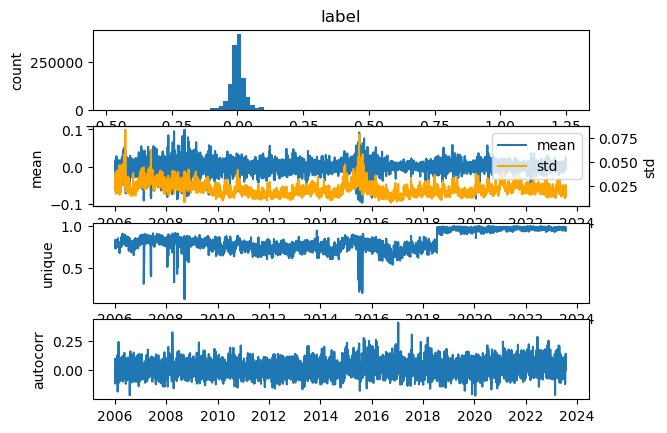

label processed:


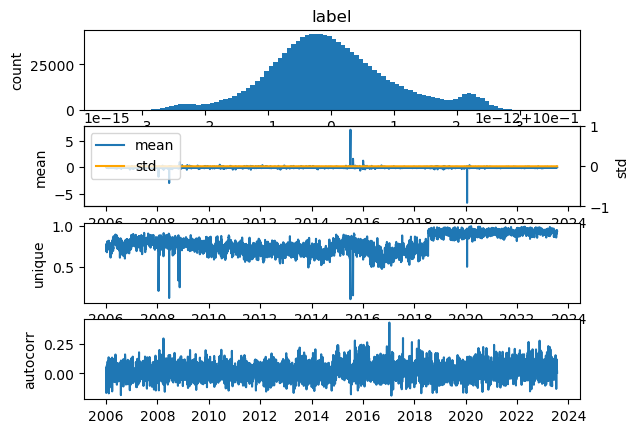

process dataset done
split data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2018-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_end_date": "2015-12-31",
        "valid_end_date": "2017-12-31"
    }
}
# 使用auto_process按照标准流程进行数据处理, 并按split_params拆分出训练集、验证集和测试集
result = q.auto_process(X, "label", split_params=split_params, unique_threshold=0.5)

X_train, y_train, X_valid, y_valid, X_test = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"], result["X_test"]

Epoch: 1 loss: 1.001053975258488 val_loss: 0.9948887956924126 val_ic: 0.05968620594476157
Epoch: 2 loss: 0.9933580035067248 val_loss: 0.9944668621069095 val_ic: 0.062339412442076435
Epoch: 3 loss: 0.9920930394048945 val_loss: 0.9933924742165159 val_ic: 0.065339848937941
Epoch: 4 loss: 0.9911191909272722 val_loss: 0.9927018271362196 val_ic: 0.06607198758651006
Epoch: 5 loss: 0.990499257418608 val_loss: 0.9923786768903498 val_ic: 0.06629935647461174
Epoch: 6 loss: 0.9900509438464887 val_loss: 0.9929626913832836 val_ic: 0.06484552764893914
Epoch: 7 loss: 0.9897789982904494 val_loss: 0.9931051451407495 val_ic: 0.06401471785397543
Epoch: 8 loss: 0.9897201638612012 val_loss: 0.9928776619375729 val_ic: 0.06444957729018214
Epoch: 9 loss: 0.9895734208845605 val_loss: 0.992823162528335 val_ic: 0.06486569086879827
Epoch: 10 loss: 0.9894675450787941 val_loss: 0.9927665243139032 val_ic: 0.06505534324802642


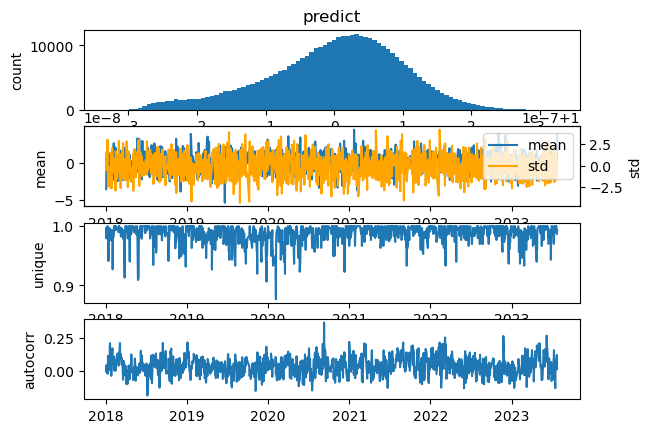

In [6]:
# 拟合模型, models模块目前实现了MLP, CNN和GRU, 另外scutquant模块还有线性模型和lightgbm
from scutquant import models


model = models.MLP(input_shape=len(X_train.columns), hidden_shape=50)
#model = models.CNN(input_channels=len(X_train.columns), hidden_channels=50, output_channels=20)
#model = models.GRU(input_shape=len(X_train.columns), hidden_shape=50)
model.fit(X_train, y_train, X_valid, y_valid)
# model.save()

pred = model.predict_pandas(X_test).to_frame(name="predict")
pred["predict"] = alpha.cs_zscore(alpha.mad_winsor(pred["predict"]))

report.single_factor_ana(pred["predict"])

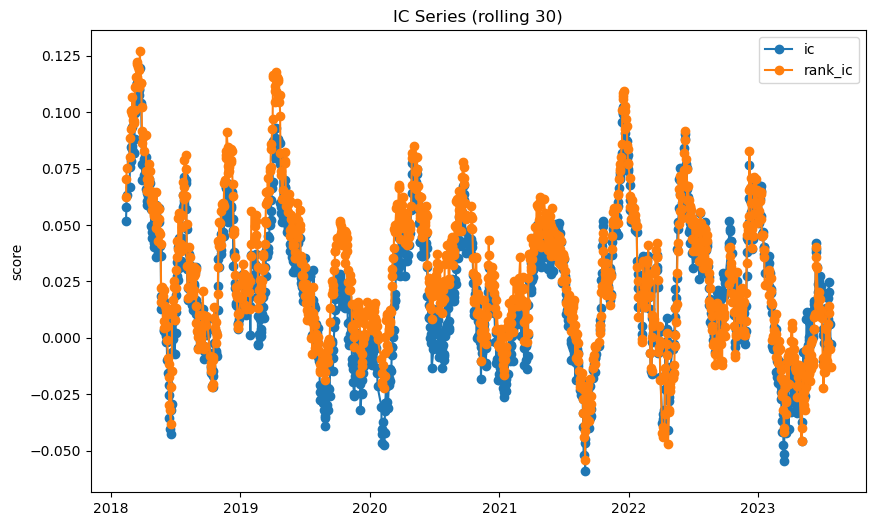

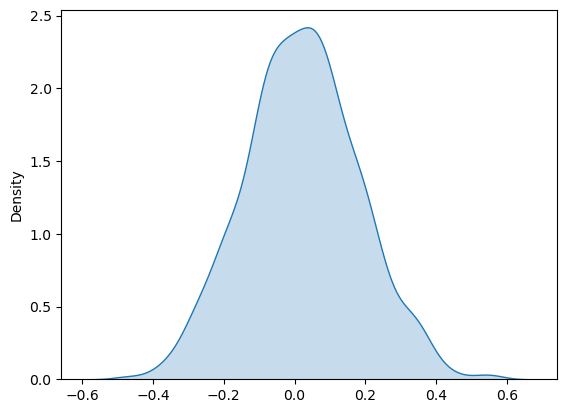

ic= 0.020119093712139914 icir= 0.1251468145406958 rank_ic= 0.0277418677849635 rank_icir= 0.16889114890593332


In [7]:
df_test = df[df.index.isin(pred.index)]
target = df_test["label"]  # 真实收益率
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, target, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [8]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume), 注意因为是第二天才开仓, 所以price做了shift(-1)
pred = executor.prepare(pred, df_test, price='close', volume='volume', real_ret=target)

Accuracy of Prediction: 0.530059345701177


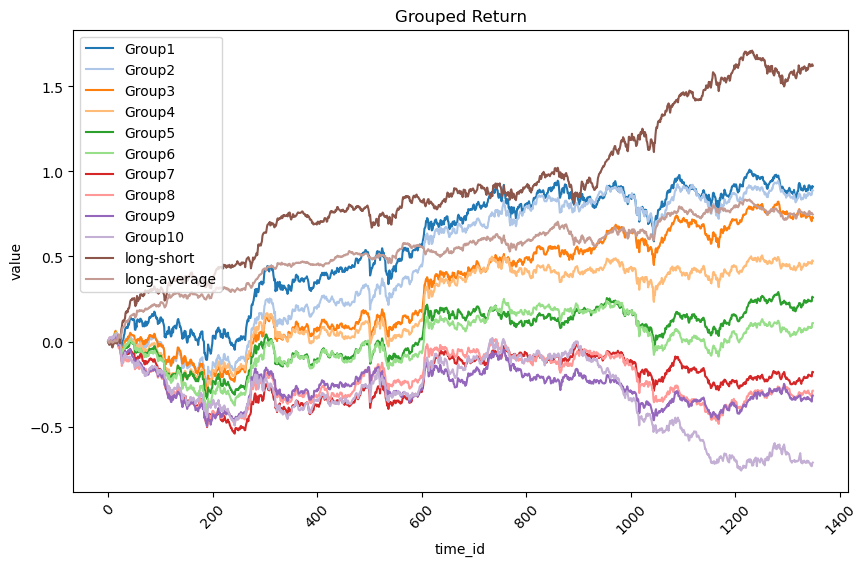

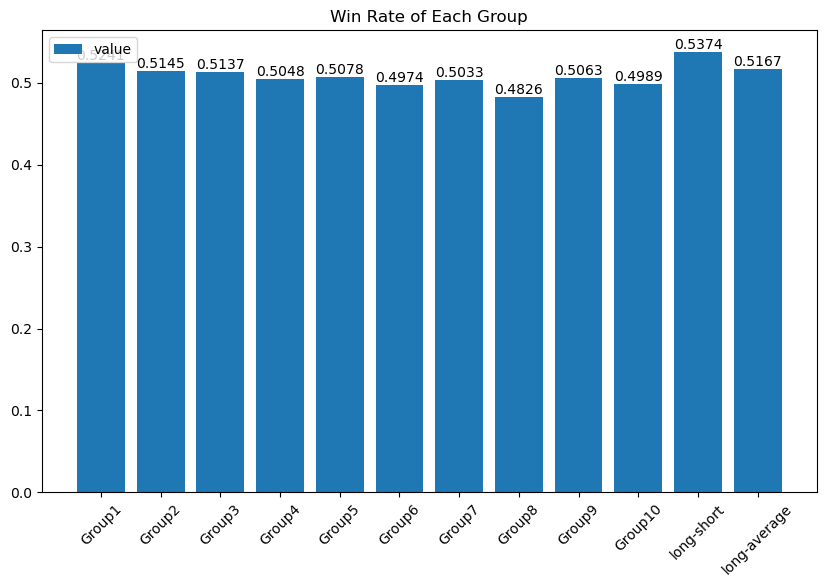

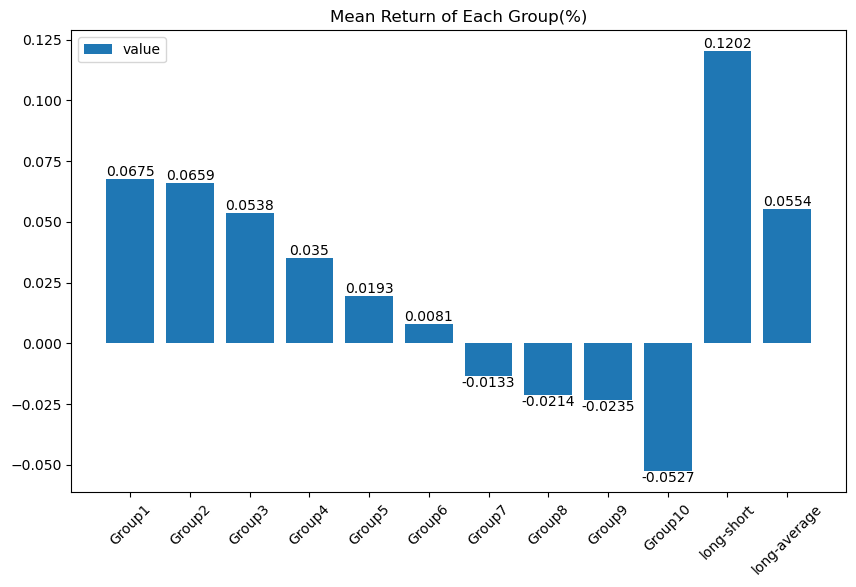

In [9]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, target)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前k*100%的股票, 做空后k*100%的股票.
        "kwargs": {
            "k": 0.1,
        }
    },
    "account": {
        "cash": 2e8,  # 初始资金
    }, 
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.05075893266016673
Annualized Volatility: 0.09195391277330695
Annualized Return(Benchmark): 0.00972963188424858
Annualized Volatility(Benchmark): 0.05833156892653668 

Cumulative Rate of Return: 0.3034962887485573
Cumulative Rate of Return(Benchmark): 0.05319949466259444
Cumulative Excess Rate of Return: 0.25029679408596284 

Max Drawdown: -0.28984321369840715
Max Drawdown(Benchmark): -0.34684122866726913
Max Drawdown(Excess Return): -0.17032029376610586 

Sharpe Ratio: 1.0433517269302255
Sortino Ratio: 10.746784777946392
Information Ratio: 2.2764184177954583 

Beta: 1.4608731412034897
Alpha: 0.2345130541175853
Epsilon: 0.07994543866254904
Profitable Days(%): 0.9881393624907339


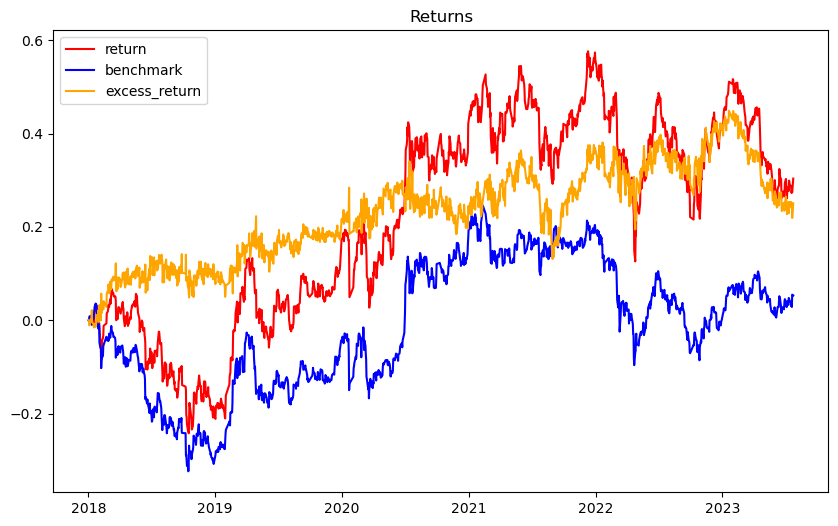

<Figure size 640x480 with 0 Axes>

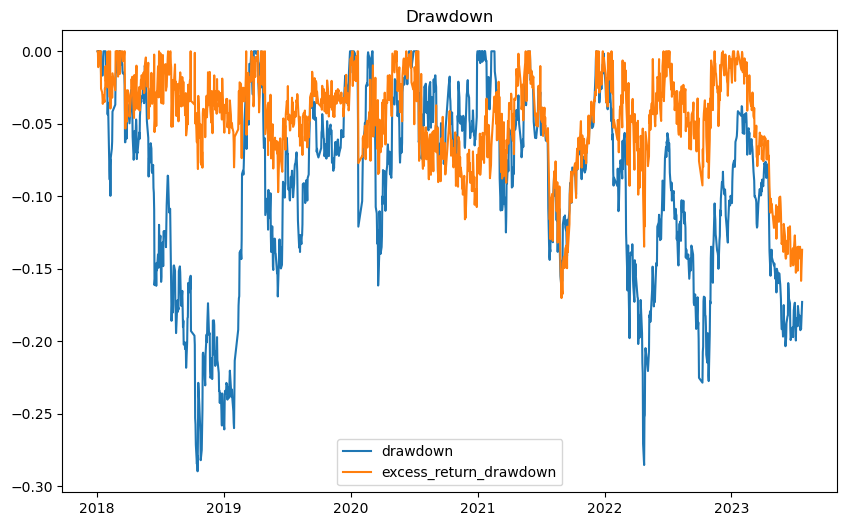

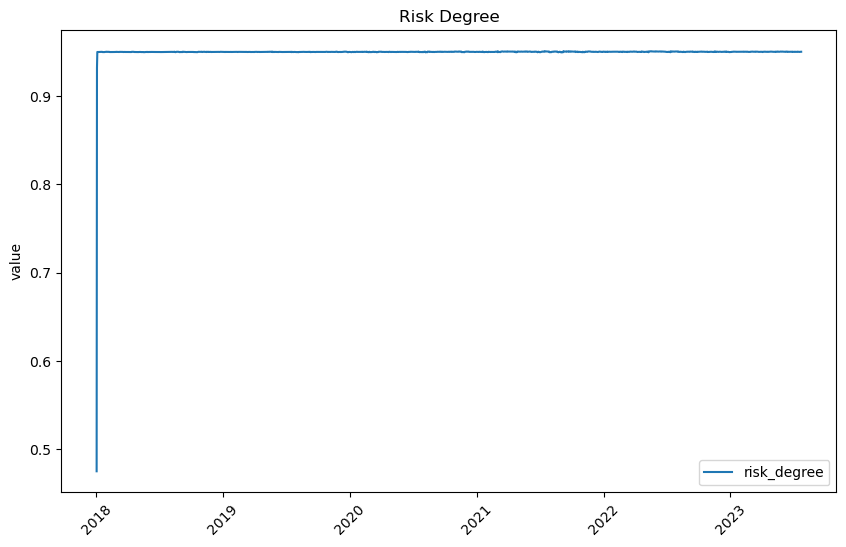

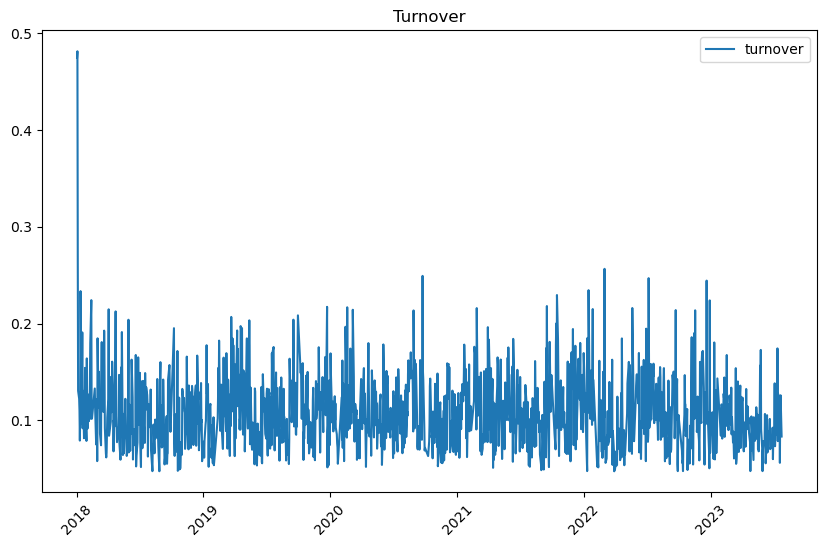

In [11]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [12]:
# user_account.position